In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ex. 8

In [2]:
X = np.random.normal(size=100)
eps = np.random.normal(size=100)
y = 3 + 5 * X - 4 * X ** 2 + X ** 3 + eps

In [3]:
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm

def test_k(X, y, k):
    models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
    return k, max(models, key=lambda model: model[1])[0]

def best_subset_selection(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        
        futures = [executor.submit(test_k, X, y, k) for k in range(1, p + 1)]
        for future in as_completed(futures):
            best_of_k[future.result()[0]] = future.result()[1]
            if verbose:
                print(future.result()[0], future.result()[1])
        
    return best_of_k

In [4]:
def forward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    for k in range(1, p + 1):
        names_candidates = [best_of_k[k - 1] + [name] for name in X.columns if name not in best_of_k[k - 1]]
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in names_candidates]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [5]:
def backward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[p] = X.columns.tolist()
    best_of_k[0] = []

    for k in range(p - 1, 0, -1):
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(best_of_k[k+1], k)]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [6]:
def evaluate(best_of_k, X, y):
    metrics = pd.DataFrame(columns=['RSS', 'R_squared_adj', 'AIC', 'BIC'])

    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(y, np.ones(y.shape)).fit()
        else:
            model = sm.OLS(y, sm.add_constant(X[list(names)])).fit()
        metrics.loc[k] = [model.ssr, model.rsquared_adj, model.aic, model.bic]
    metrics.sort_index(inplace=True)

    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, col in enumerate(metrics.columns):
        sns.pointplot(metrics.index, metrics[col], marker='o', ax=axes[i%2, i//2], label=col,)
        best = metrics[col].argmax() if col == 'R_squared_adj' else metrics[col].argmin()
        axes[i%2, i//2].set_title(f'Best: {best}')
        sns.scatterplot([best], [metrics[col][best]], marker='o', s=200, color='m', ax=axes[i%2, i//2])

In [7]:
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

In [8]:
%%time
best_models = best_subset_selection(data, y)

1 ('X^3',)
2 ('X^1', 'X^2')
3 ('X^1', 'X^2', 'X^3')
4 ('X^1', 'X^2', 'X^3', 'X^7')
7 ('X^1', 'X^2', 'X^3', 'X^6', 'X^8', 'X^9', 'X^10')
5 ('X^1', 'X^2', 'X^3', 'X^4', 'X^9')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
8 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^8', 'X^9', 'X^10')
6 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^7')
CPU times: user 38.2 ms, sys: 20.7 ms, total: 58.9 ms
Wall time: 1.68 s


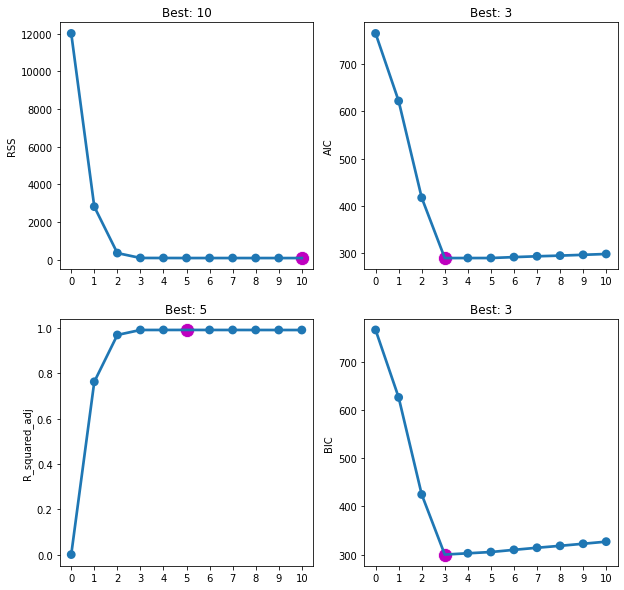

In [9]:
evaluate(best_models, data, y)

All scores show that model with 3 predictors is the best one.

In [10]:
model = sm.OLS(y, sm.add_constant(data[['X^1', 'X^2', 'X^3']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3897.
Date:                Wed, 16 Sep 2020   Prob (F-statistic):          4.15e-100
Time:                        19:16:14   Log-Likelihood:                -140.78
No. Observations:                 100   AIC:                             289.6
Df Residuals:                      96   BIC:                             300.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1076      0.133     23.319      0.000       2.843       3.372
X^1            5.1895      0.184     28.278      0.000       4.825       5.554
X^2           -3.9950      0.083    -48.224      0.000      -4.159      -3.831
X^3            0.9529      0.060     15.964      0.000       0.834       1.071
==============================================================================
Omnibus:                        1.047   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.563
Skew:                           0.097   Prob(JB):                        0.755
Kurtosis:                       3.313   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All coefficient are good estimations of real ones.

1 ['X^3']
2 ['X^3', 'X^2']
3 ['X^3', 'X^2', 'X^1']
4 ['X^3', 'X^2', 'X^1', 'X^7']
5 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4']
6 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4', 'X^5']
7 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4', 'X^5', 'X^9']
8 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4', 'X^5', 'X^9', 'X^8']
9 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4', 'X^5', 'X^9', 'X^8', 'X^6']
10 ['X^3', 'X^2', 'X^1', 'X^7', 'X^4', 'X^5', 'X^9', 'X^8', 'X^6', 'X^10']
CPU times: user 525 ms, sys: 9.15 ms, total: 534 ms
Wall time: 527 ms


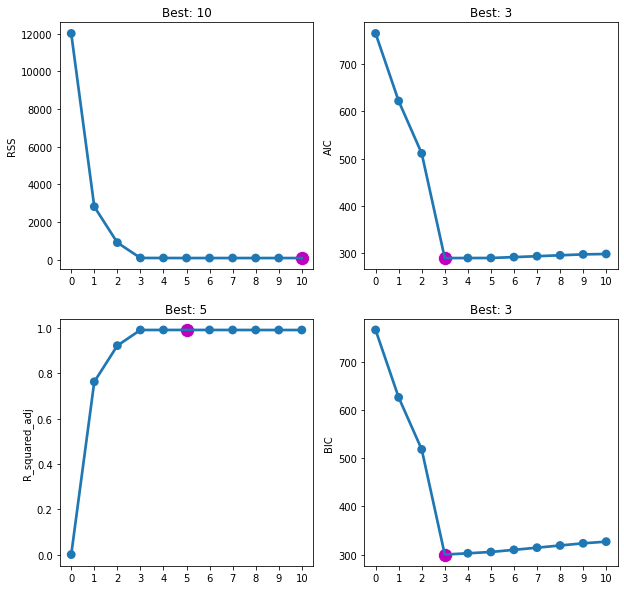

In [11]:
%%time
best_models = forward_stepwise_selection(data, y)
evaluate(best_models, data, y)

9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
8 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^8', 'X^9', 'X^10')
7 ('X^1', 'X^2', 'X^3', 'X^6', 'X^8', 'X^9', 'X^10')
6 ('X^1', 'X^2', 'X^3', 'X^6', 'X^8', 'X^9')
5 ('X^1', 'X^2', 'X^3', 'X^6', 'X^9')
4 ('X^1', 'X^2', 'X^3', 'X^9')
3 ('X^1', 'X^2', 'X^3')
2 ('X^1', 'X^2')
1 ('X^1',)
CPU times: user 536 ms, sys: 621 µs, total: 537 ms
Wall time: 535 ms


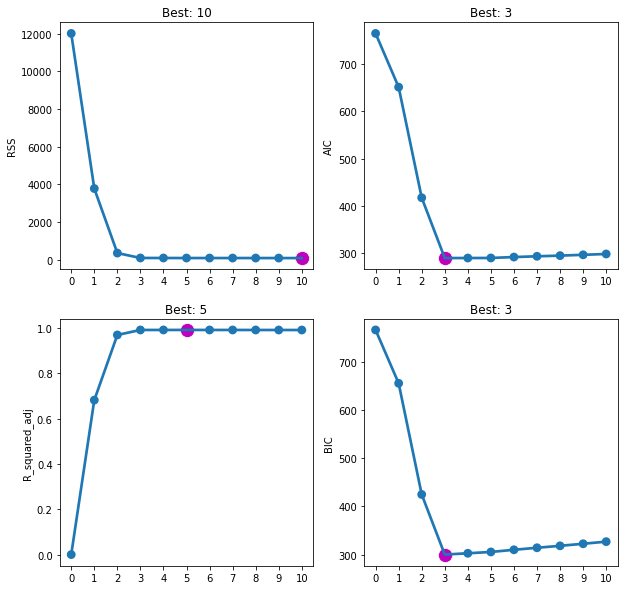

In [12]:
%%time
best_models = backward_stepwise_selection(data, y)
evaluate(best_models, data, y)

Results for forward stepwise selection is the same as with best subset selection. Backward stepwise selection has worse results. It had removed the third predictor almost at start.

In [13]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse

In [14]:
data = data / data.std()

In [15]:
lambdas = np.logspace(-3, 1, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l, normalize=False, max_iter=2000).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

0.011


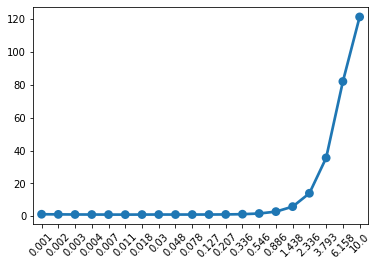

In [16]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [17]:
best_model = Lasso(alpha=best, normalize=False).fit(data, y)
best_model.coef_

array([ 5.24623187, -5.05178916,  3.53076542, -0.40831076,  0.        ,
       -0.        , -0.        ,  0.        , -0.37451998,  0.        ])

The coeficients show that lasso was able to cut almost all unrelated variables. But also remaining coeficients differ a little from original ones.

In [18]:
np.random.seed(1)
X = np.random.normal(size=500)
eps = np.random.normal(size=500)
y = 8 + 12 * X ** 7 + eps
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

1 ('X^7',)
2 ('X^7', 'X^10')
3 ('X^2', 'X^6', 'X^7')
4 ('X^4', 'X^6', 'X^7', 'X^8')
8 ('X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
6 ('X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^10')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
5 ('X^2', 'X^3', 'X^4', 'X^5', 'X^7')
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
7 ('X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
CPU times: user 347 ms, sys: 34.7 ms, total: 382 ms
Wall time: 2.53 s


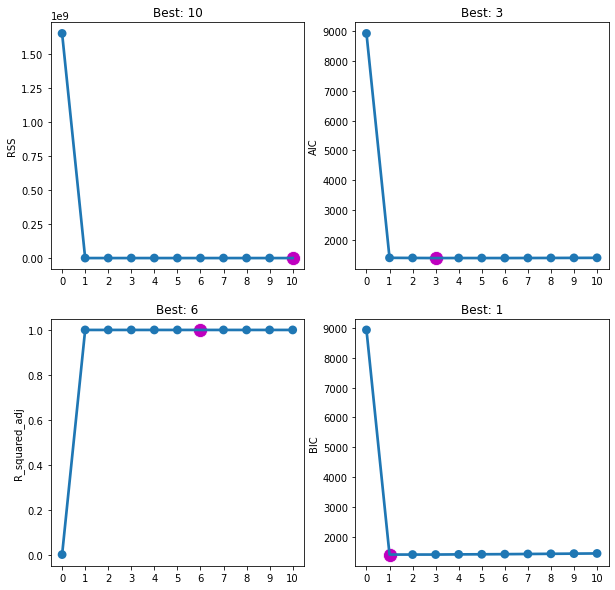

In [19]:
%%time
best_models = best_subset_selection(data, y)
evaluate(best_models, data, y)

In [20]:
model = sm.OLS(y, sm.add_constant(data[['X^7']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.737e+09
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:16:22   Log-Likelihood:                -695.58
No. Observations:                 500   AIC:                             1395.
Df Residuals:                     498   BIC:                             1404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0242      0.044    184.110      0.000       7.939       8.110
X^7           12.0002      0.000   4.17e+04      0.000      12.000      12.001
==============================================================================
Omnibus:                        5.024   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                6.141
Skew:                          -0.086   Prob(JB):                       0.0464
Kurtosis:                       3.515   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results are as expected.

24.421


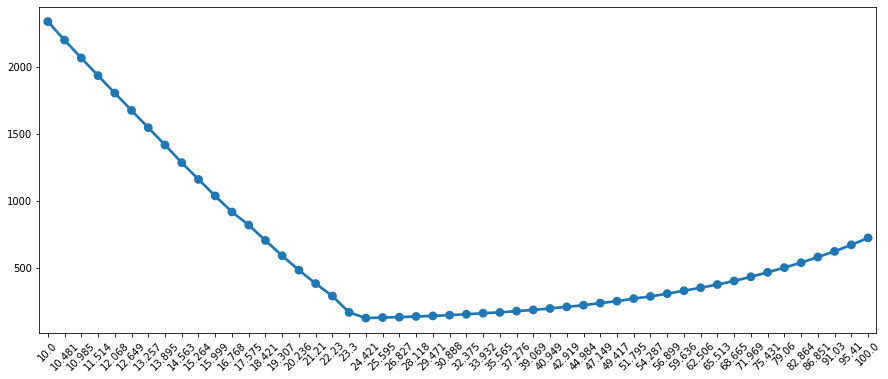

In [21]:
# data = data / data.std()
lambdas = np.logspace(1, 2, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=2)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [22]:
train_X, test_X, train_y, test_y = train_test_split(data, y, test_size=0.25, random_state=3)
best_lasso = Lasso(alpha=best, normalize=False).fit(train_X, train_y)
best_bss = sm.OLS(train_y, sm.add_constant(train_X[['X^7']])).fit()
best_lasso.intercept_, best_lasso.coef_

(8.029958631061739,
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.04293365e+00,  1.07053952e-02,  1.12021278e+01,  0.00000000e+00,
         6.71291893e-02, -1.33345881e-03]))

In [23]:
print('Lasso:', mse(test_y, best_lasso.predict(test_X)))
print('BSS  :', mse(test_y, best_bss.predict(sm.add_constant(test_X[['X^7']]))))

Lasso: 10.745633952287742
BSS  : 0.8083075141056256


Lasso had left too much unnecessary variables.

# Ex. 9

In [24]:
dataset_file = '../datasets/College.csv'
data = pd.read_csv(dataset_file)
data.Private = data.Private.apply(lambda v: 1 if v == 'Yes' else 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    int64  
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(17)
memory usage: 109.4 KB


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [26]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=1)

train_X = train_data.drop(['Apps'], axis=1)
test_X = test_data.drop(['Apps'], axis=1)
train_y = train_data.Apps
test_y = test_data.Apps

std_train_X = train_X / train_X.std()
std_test_X = test_X / test_X.std()

errors = pd.Series(dtype=np.float64)
R_squared = pd.Series(dtype=np.float64)

In [27]:
least_squares_model = LinearRegression().fit(std_train_X, train_y)
least_squres_pred = least_squares_model.predict(std_test_X)
errors['Least Squares'] = mse(test_y, least_squres_pred)
R_squared['Least Squares'] = r2_score(test_y, least_squres_pred)
errors['Least Squares']

874031.7127195649

0.01


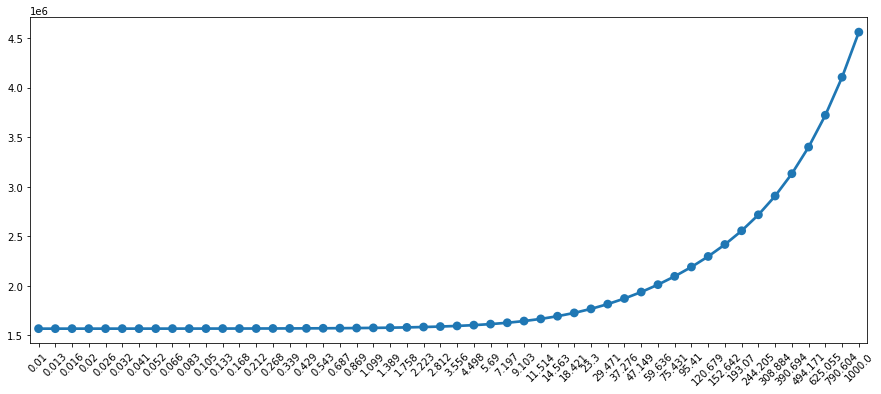

In [28]:
lambdas = np.logspace(-2, 3, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_train_X):
        model = Ridge(alpha=l).fit(std_train_X.iloc[train], train_y.iloc[train])
        lambda_res.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [29]:
ridge_model = Ridge(alpha=best).fit(std_train_X, train_y)
ridge_pred = ridge_model.predict(std_test_X)
errors['Ridge'] = mse(test_y, ridge_pred)
R_squared['Ridge'] = r2_score(test_y, ridge_pred)
errors['Ridge']

873959.5818949381

14.563


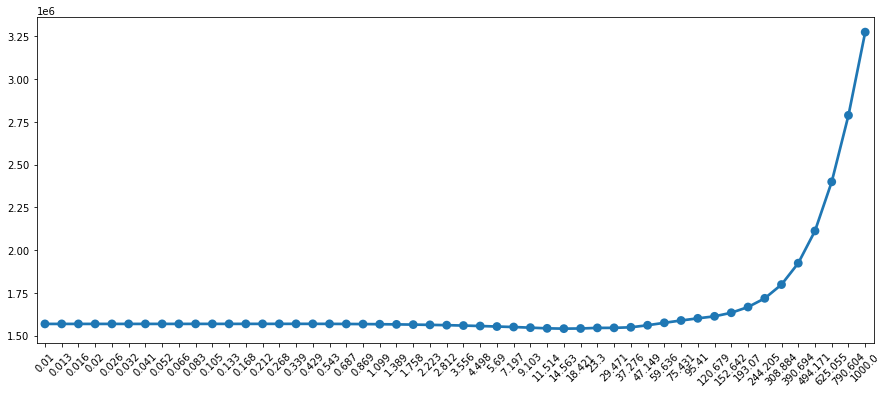

In [30]:
lambdas = np.logspace(-2, 3, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_train_X):
        model = Lasso(alpha=l).fit(std_train_X.iloc[train], train_y.iloc[train])
        lambda_res.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [31]:
lasso_model = Lasso(alpha=best).fit(std_train_X, train_y)
print('Non zero:', lasso_model.coef_.nonzero()[0].size)
lasso_pred = lasso_model.predict(std_test_X)
errors['Lasso'] = mse(test_y, lasso_pred)
R_squared['Lasso'] = r2_score(test_y, lasso_pred)
errors['Lasso']

Non zero: 14


833445.2827955161

In [32]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

17


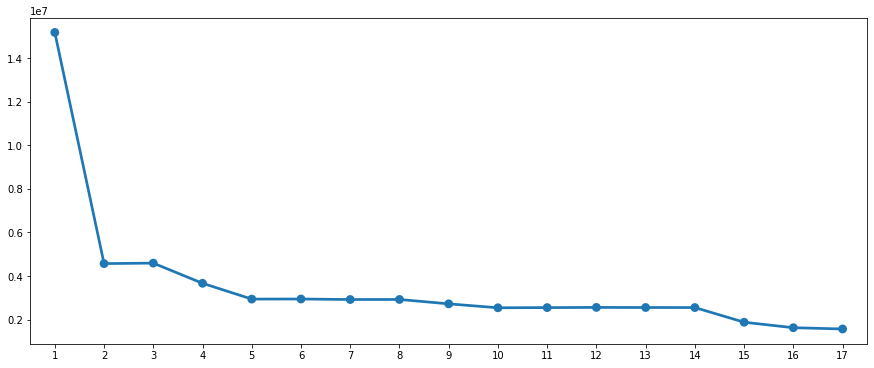

In [33]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

res = pd.Series(index=pd.RangeIndex(1, std_train_X.shape[1]), dtype=np.float64)
pca = PCA()
X_reduced_train = pca.fit_transform(std_train_X)
for num_components in range(1, X_reduced_train.shape[1] + 1):
    cv_scores = []
    for train, test in cv.split(X_reduced_train):
        model = LinearRegression().fit(X_reduced_train[train, :num_components], train_y.iloc[train])
        cv_scores.append(mse(train_y.iloc[test], model.predict(X_reduced_train[test, :num_components])))
    res.loc[num_components] = np.mean(cv_scores)

plt.figure(figsize=(15, 6))
sns.pointplot(res.index, res)
best = res.index[res.argmin()]
print(best)

In [34]:
X_reduced_test = pca.transform(std_test_X)
pcr_model_17 = LinearRegression().fit(X_reduced_train[:, :best], train_y)
pcr_pred_17 = pcr_model_17.predict(X_reduced_test[:, :best])
errors['PCR_17'] = mse(test_y, pcr_pred_17)
R_squared['PCR_17'] = r2_score(test_y, pcr_pred_17)

pcr_model_10 = LinearRegression().fit(X_reduced_train[:, :10], train_y)
pcr_pred_10 = pcr_model_10.predict(X_reduced_test[:, :10])
errors['PCR_10'] = mse(test_y, pcr_pred_10)
R_squared['PCR_10'] = r2_score(test_y, pcr_pred_10)

errors[['PCR_17', 'PCR_10']]

PCR_17    8.740317e+05
PCR_10    1.421202e+06
dtype: float64

17


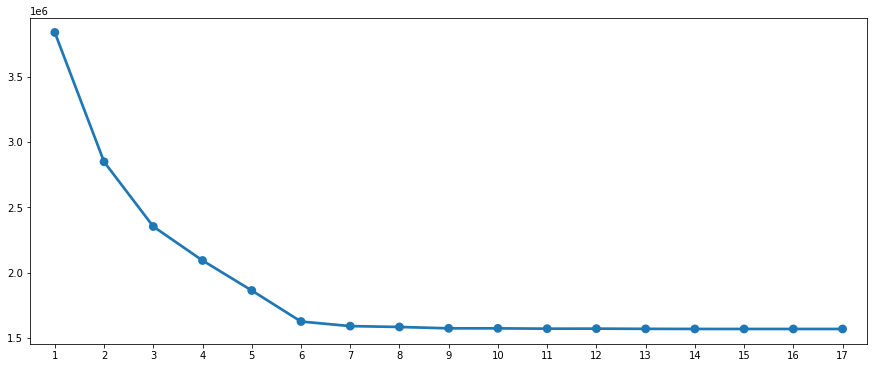

In [35]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

res = pd.Series(index=pd.RangeIndex(1, std_train_X.shape[1]), dtype=np.float64)
for num_components in range(1, std_train_X.shape[1] + 1):
    cv_scores = []
    for train, test in cv.split(std_train_X):
        model = PLSRegression(n_components=num_components).fit(std_train_X.iloc[train], train_y.iloc[train])
        cv_scores.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[num_components] = np.mean(cv_scores)

plt.figure(figsize=(15, 6))
sns.pointplot(res.index, res)
best = res.index[res.argmin()]
print(best)

In [36]:
plsr_model_17 = PLSRegression(n_components=best).fit(std_train_X, train_y)
plsr_pred_17 = plsr_model_17.predict(std_test_X)
errors['PLSR_17'] = mse(test_y, plsr_pred_17)
R_squared['PLSR_17'] = r2_score(test_y, plsr_pred_17)

plsr_model_9 = PLSRegression(n_components=9).fit(std_train_X, train_y)
plsr_pred_9 = plsr_model_9.predict(std_test_X)
errors['PLSR_9'] = mse(test_y, plsr_pred_9)
R_squared['PLSR_9'] = r2_score(test_y, plsr_pred_9)

errors[['PLSR_17', 'PLSR_9']]

PLSR_17    874031.71272
PLSR_9     842831.86992
dtype: float64

In [37]:
errors

Least Squares    8.740317e+05
Ridge            8.739596e+05
Lasso            8.334453e+05
PCR_17           8.740317e+05
PCR_10           1.421202e+06
PLSR_17          8.740317e+05
PLSR_9           8.428319e+05
dtype: float64

In [38]:
R_squared

Least Squares    0.931927
Ridge            0.931933
Lasso            0.935088
PCR_17           0.931927
PCR_10           0.889311
PLSR_17          0.931927
PLSR_9           0.934357
dtype: float64

The results show that there is not much difference among models. Ridge regression performs almost the same as Least Squares. Lasso had managed to cut out 3 variables and has the best R squared value on test data. PCR was unable to perform any useful dimentionality reduction, using 10 component gives a huge decrease in model performance. PLSR CV shows that the model with all 17 components is the best, however one can effectivly use only 8 or 9 components without a substantial decrease in model performance.

# Ex. 10

In [77]:
n = 1000
p = 20
np.random.seed(4)
X = np.random.normal(size=n*p).reshape(n, p)
X = pd.DataFrame(X, columns=[i for i in range(1, p+1)])
eps = np.random.normal(size=n)
B = np.random.uniform(-10, 10, size=p).round()
y = np.dot(X, B) + eps
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.9)

In [79]:
best_models = best_subset_selection(train_X, train_y)

1 (9,)
2 (1, 9)
3 (1, 7, 9)
4 (1, 7, 9, 15)
5 (1, 4, 7, 9, 15)
6 (1, 7, 9, 14, 15, 17)
7 (1, 4, 7, 9, 10, 15, 19)
8 (1, 4, 7, 9, 14, 15, 17, 19)
9 (1, 4, 7, 9, 10, 14, 15, 17, 19)
10 (1, 4, 7, 9, 10, 13, 14, 15, 17, 19)
11 (1, 4, 7, 9, 10, 11, 13, 14, 15, 17, 19)
12 (1, 3, 4, 7, 9, 10, 11, 13, 14, 15, 17, 19)
14 (1, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19)
13 (1, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15, 17, 19)
15 (1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19)
19 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20)
20 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
18 (1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20)
16 (1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19)
17 (1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20)


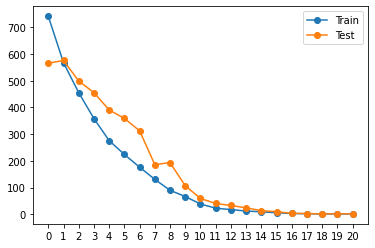

In [122]:
train_mse = pd.Series(index=pd.RangeIndex(p+1), dtype=np.float64)
test_mse = pd.Series(index=pd.RangeIndex(p+1), dtype=np.float64)

for k, names in best_models.items():
    if k == 0:
        model = sm.OLS(train_y, np.ones(train_y.shape)).fit()
    else:
        model = sm.OLS(train_y, sm.add_constant(train_X[list(names)])).fit()
    train_mse[k] = mse(train_y, model.predict(sm.add_constant(train_X[list(names)])))
    test_mse[k] = mse(test_y, model.predict(sm.add_constant(test_X[list(names)])))

plt.plot(train_mse.index, train_mse, 'o-', label='Train')
plt.plot(test_mse.index, test_mse, 'o-', label='Test')
plt.legend()
plt.xticks(train_mse.index)
train_best = train_mse.argmin()
test_best = test_mse.argmin()

In [95]:
print('Best model num of variables:', test_best)
print('Best model variables:', best_models[test_best])
print('Non-zero betas:', B.nonzero()[0] + 1)

Best model num of variables: 18
Best model variables: (1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20)
Non-zero betas: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 19 20]


Test MSE is the lowest for model with 18 variables, which is as expected, because original model has 18 non-zero betas.

In [117]:
best_model = sm.OLS(train_y, sm.add_constant(train_X[list(best_models[test_best])])).fit()
print(best_model.params.round(2).tolist()[1:])
print(B[B.nonzero()].tolist())

[8.86, -2.12, 2.92, 7.07, -2.05, 7.0, -3.05, 9.1, 7.91, -4.07, 1.87, -5.92, 6.97, -9.18, 0.92, -5.95, -9.09, 1.03]
[9.0, -2.0, 3.0, 7.0, -2.0, 7.0, -3.0, 9.0, 8.0, -4.0, 2.0, -6.0, 7.0, -9.0, 1.0, -6.0, -9.0, 1.0]


In [118]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3405.
Date:                Wed, 16 Sep 2020   Prob (F-statistic):          9.78e-109
Time:                        21:12:59   Log-Likelihood:                -140.85
No. Observations:                 100   AIC:                             319.7
Df Residuals:                      81   BIC:                             369.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0205      0.120     -0.171      0.865      -0.259       0.218
1              8.8611      0.108     82.087      0.000       8.646       9.076
2             -2.1234      0.124    -17.171      0.000      -2.369      -1.877
3              2.9212      0.120     24.284      0.000       2.682       3.161
4              7.0701      0.116     60.942      0.000       6.839       7.301
6             -2.0485      0.131    -15.632      0.000      -2.309      -1.788
7              6.9997      0.113     61.769      0.000       6.774       7.225
8             -3.0460      0.130    -23.450      0.000      -3.304      -2.788
9              9.0956      0.151     60.097      0.000       8.794       9.397
10             7.9141      0.140     56.456      0.000       7.635       8.193
11            -4.0709      0.117    -34.849      0.000      -4.303      -3.839
12             1.8702      0.101     18.465      0.000       1.669       2.072
13            -5.9211      0.120    -49.256      0.000      -6.160      -5.682
14             6.9662      0.131     53.256      0.000       6.706       7.226
15            -9.1787      0.126    -72.942      0.000      -9.429      -8.928
16             0.9227      0.134      6.889      0.000       0.656       1.189
17            -5.9499      0.123    -48.190      0.000      -6.196      -5.704
19            -9.0938      0.134    -68.004      0.000      -9.360      -8.828
20             1.0309      0.107      9.592      0.000       0.817       1.245
==============================================================================
Omnibus:                        0.611   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.737   Jarque-Bera (JB):                0.516
Skew:                          -0.174   Prob(JB):                        0.773
Kurtosis:                       2.951   Cond. No.                         2.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model approximates original coeficients very good. Also p-values associated with coeficients are all very low.

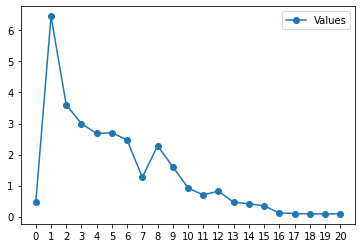

In [144]:
values = pd.Series(index=pd.RangeIndex(p+1), dtype=np.float64)

for k, names in best_models.items():
    if k == 0:
        model = sm.OLS(train_y, np.ones(train_y.shape)).fit()
        values[k] = np.abs(model.params[0])
    else:
        model = sm.OLS(train_y, sm.add_constant(train_X[list(names)])).fit()
        values[k] = mse(B[np.array(names) - 1], model.params[1:]) ** 0.5

plt.plot(values.index, values, 'o-', label='Values')
plt.xticks(train_mse.index)
plt.legend()

Both plots have some similarities in sense that they go up and down simultaneously.

# Ex. 11